In [1]:
from data_generator.main import DiscriminationData
import pandas as pd
from typing import List, Dict
from sqlalchemy import create_engine
import json
from concurrent.futures import ThreadPoolExecutor
from functools import partial
from tqdm.auto import tqdm
import numpy as np


def calculate_correlation_matrices(db_path: str, experiment_ids: List[str]) -> tuple[pd.DataFrame, pd.DataFrame]:
    # Create connection pool for thread safety
    engine = create_engine(f'sqlite:///{db_path}', pool_size=len(experiment_ids), max_overflow=0)

    def sort_couple_key(couple_key: str) -> str:
        """Vectorized couple key sorting"""
        indiv1, indiv2 = couple_key.split('-')
        return f"{min(indiv1, indiv2)}-{max(indiv1, indiv2)}"

    def prepare_result_combinations(df: pd.DataFrame, feature_cols: List[str]) -> pd.DataFrame:
        # Vectorized operations for result combinations
        df['sorted_couple_key'] = df['couple_key'].apply(sort_couple_key)

        # Group by couple key and process all at once
        grouped = df.groupby('sorted_couple_key')
        valid_couples = grouped.filter(lambda x: len(x) == 2)

        # Prepare feature combinations using vectorized operations
        combinations_list = []
        for _, couple_data in valid_couples.groupby('sorted_couple_key'):
            if couple_data.shape[0] != 2:
                continue

            is_part_of_group = couple_data['is_couple_part_of_a_group'].iloc[0] != '0'
            features = couple_data[feature_cols].values

            combination = {
                'couple_key': couple_data['sorted_couple_key'].iloc[0],
                'is_part_of_group': is_part_of_group
            }

            for idx, feat in enumerate(feature_cols):
                combination[f'{feat}_1'] = features[0][idx]
                combination[f'{feat}_2'] = features[1][idx]

            combinations_list.append(combination)

        return pd.DataFrame(combinations_list)

    def compute_distances(synth_features: np.ndarray, result_features: np.ndarray,
                          batch_size: int = 5000) -> np.ndarray:
        """Optimized distance computation with larger batches and vectorized operations"""
        n_synth = len(synth_features)
        n_result = len(result_features)
        distance_matrix = np.zeros((n_synth, n_result))

        for i in range(0, n_synth, batch_size):
            batch_end = min(i + batch_size, n_synth)
            batch = synth_features[i:batch_end]

            # Vectorized distance calculation
            distances = np.sqrt(((batch[:, np.newaxis, :] - result_features) ** 2).sum(axis=2))
            distance_matrix[i:batch_end] = distances

        return distance_matrix

    def calculate_distance_stats(synth_df: pd.DataFrame, distance_matrix: np.ndarray) -> pd.DataFrame:
        """Vectorized distance statistics calculation"""
        unique_groups = synth_df['group_key'].unique()
        group_indices = [synth_df['group_key'] == group for group in unique_groups]

        stats = pd.DataFrame({
            'group_key': unique_groups,
            'min_distance': [np.min(distance_matrix[idx]) for idx in group_indices],
            'max_distance': [np.max(distance_matrix[idx]) for idx in group_indices],
            'mean_distance': [np.mean(distance_matrix[idx]) for idx in group_indices],
            'median_distance': [np.median(distance_matrix[idx]) for idx in group_indices]
        }).set_index('group_key')

        return stats

    def process_experiment(experiment_id: str, engine, pbar: tqdm) -> tuple[str, pd.DataFrame, pd.DataFrame]:
        """Process a single experiment with progress tracking"""
        try:
            pbar.set_description(f"Processing {experiment_id}")

            # Load data efficiently
            with engine.connect() as conn:
                df_synth = pd.read_sql_query(
                    f"SELECT full_data FROM synthetic_data WHERE experiment_id='{experiment_id}'",
                    conn
                )
                if df_synth.empty:
                    pbar.update(1)
                    return experiment_id, pd.DataFrame(), pd.DataFrame()

                df_synth = pd.DataFrame(json.loads(df_synth['full_data'].iloc[0]))
                df_synth['calculated_epistemic'] = df_synth['epis_uncertainty']
                df_synth['calculated_aleatoric'] = df_synth['alea_uncertainty']
                df_synth['experiment_id'] = experiment_id

                df_result = pd.read_sql_query(
                    f"""SELECT * FROM augmented_results ar
                LEFT JOIN main.analysis_metadata am ON am.analysis_id=ar.analysis_id
                WHERE experiment_id='{experiment_id}'""", conn)

                if df_result.empty:
                    pbar.update(1)
                    return experiment_id, pd.DataFrame(), pd.DataFrame()

            # Process data
            feature_cols = [col for col in df_synth.columns if 'Attr' in col]

            synth_combinations = DiscriminationData.generate_individual_synth_combinations(df_synth)

            df_result_data = pd.DataFrame(list(df_result['data'].apply(json.loads)))
            df_result = pd.concat([df_result.reset_index(drop=True), df_result_data.reset_index(drop=True)], axis=1)
            result_combinations = prepare_result_combinations(df_result, feature_cols)

            # Calculate distances
            comb_feature_cols = [col for col in synth_combinations.columns if 'Attr' in col]
            synth_features = synth_combinations[comb_feature_cols].to_numpy()
            result_features = result_combinations[comb_feature_cols].to_numpy()

            distance_matrix = compute_distances(synth_features, result_features)
            distance_stats = calculate_distance_stats(synth_combinations, distance_matrix)

            # Merge and calculate correlations
            merged_df = df_synth.join(distance_stats, on='group_key', how='left')
            calc_cols = [col for col in merged_df.columns if col.startswith("calculated")]
            dist_cols = [col for col in merged_df.columns if col.endswith("distance")]

            correlations_df = merged_df[['group_key'] + calc_cols + dist_cols].drop_duplicates()
            correlations = np.corrcoef(correlations_df[calc_cols].T, correlations_df[dist_cols].T)

            # Extract relevant correlation coefficients
            n_calc = len(calc_cols)
            correlation_matrix = correlations[:n_calc, n_calc:]

            pbar.update(1)
            return experiment_id, pd.DataFrame(correlation_matrix, index=calc_cols, columns=dist_cols), correlations_df

        except Exception as e:
            print(f"Error processing experiment {experiment_id}: {str(e)}")
            pbar.update(1)
            return experiment_id, pd.DataFrame(), pd.DataFrame()

    # Create progress bar
    pbar = tqdm(total=len(experiment_ids), desc="Overall Progress")

    # Process experiments in parallel with progress tracking
    with ThreadPoolExecutor(max_workers=min(len(experiment_ids), 4)) as executor:
        results = list(executor.map(partial(process_experiment, engine=engine, pbar=pbar), experiment_ids))

    pbar.close()

    # Combine results
    matrices = {exp_id: matrix for exp_id, matrix, correlations_df in results if not matrix.empty}
    metrics_df = pd.concat(matrices, axis=0, names=['experiment_id', 'calculated_metric'])

    correlations_dfs = {exp_id: correlations_df for exp_id, matrix, correlations_df in results if not matrix.empty}
    distances_df = pd.concat(correlations_dfs, axis=0, names=['experiment_id', 'distances'])

    return metrics_df, distances_df


In [ ]:
import random
import pandas as pd
from itertools import product
import math

import re
from functools import lru_cache


@lru_cache(maxsize=1024)
def compile_pattern(pattern_string: str, data_schema: str) -> re.Pattern:
    """Compile and cache regex pattern."""

    def _compile_pattern(pattern_string: str, data_schema: str):
        res_pattern = []
        for k, v in zip(pattern_string.split('|'), data_schema.split('|')):
            if k == '*':
                res_pattern.append(f"[{v}]")
            else:
                res_pattern.append(k)
        res_pattern = "\|".join(res_pattern)
        return res_pattern

    if '-' in pattern_string:
        result_pat = []
        for pat1, pat2 in zip(pattern_string.split('-'), data_schema.split('-')):
            result_pat.append(_compile_pattern(pat1, pat2))

        return re.compile('-'.join(result_pat))

    else:
        return re.compile(_compile_pattern(pattern_string, data_schema))


@lru_cache(maxsize=4096)
def matches_pattern(pattern_string: str, test_string: str, data_schema: str) -> bool:
    """Cached pattern matching."""
    pattern = compile_pattern(pattern_string, data_schema)
    return bool(pattern.match(test_string))


def is_couple_part_of_a_group(couple_key, group_key_list, res_pattern):
    res = []

    couple_key_elems = couple_key.split('-')
    if len(couple_key_elems) != 2:
        print(f"Warning: Unexpected couple key format: {couple_key}")
        return res

    opt1 = f"{couple_key_elems[0]}-{couple_key_elems[1]}"
    opt2 = f"{couple_key_elems[1]}-{couple_key_elems[0]}"

    grp_res_pattern = f"{res_pattern}-{res_pattern}"

    for grp_key in group_key_list:
        if matches_pattern(grp_key, opt1, grp_res_pattern) or matches_pattern(grp_key, opt2, grp_res_pattern):
            res.append(grp_key)
    return res


@lru_cache(maxsize=1024)
def cached_matches_pattern(pattern: str, key: str, data_schema: str) -> bool:
    return matches_pattern(pattern, key, data_schema)


def process_row(row, group_keys, attr_possible_values):
    matching_groups = [
        group_key for group_key in df_synth['group_key'].unique() if
        cached_matches_pattern(group_key, row['couple_key'], df_synth['attr_possible_values'].iloc[0])
    ]

    return pd.Series({
        'matching_groups': matching_groups,
    })


def generate_all_combinations(column_values, column_names=None, percentage=100):
    # Validate percentage
    if not 0 < percentage <= 100:
        raise ValueError("Percentage must be between 0 and 100")

    # Calculate total possible combinations
    total_combinations = math.prod(len(values) for values in column_values)

    # Calculate how many combinations to generate
    num_combinations = int(total_combinations * (percentage / 100))
    num_combinations = max(1, num_combinations)  # Ensure at least one combination

    # Create column names if not provided
    if column_names is None:
        column_names = [f'column_{i}' for i in range(len(column_values))]

    # Generate all combinations and randomly sample
    all_combinations = list(product(*column_values))
    selected_combinations = random.sample(all_combinations, num_combinations)

    # Convert to DataFrame
    df = pd.DataFrame(selected_combinations, columns=column_names)

    return df

In [ ]:
group_keys = df_synth['group_key'].unique()
attr_possible_values = df_synth['attr_possible_values'].iloc[0]
column_values = [list(map(int, list(e))) for e in attr_possible_values.split('|')]
column_values = column_values + column_values
column_names = list(filter(lambda x: 'Attr' in x, new_synth_df.columns))
new_all_synth_df = generate_all_combinations(column_values, column_names=column_names)
mk_coupl_key = lambda \
        x: f"{'|'.join(list(map(str, x[:len(column_names) // 2])))}-{'|'.join(list(map(str, x[len(column_names) // 2:])))}"
new_all_synth_df['couple_key'] = new_all_synth_df.apply(mk_coupl_key, axis=1)
new_all_synth_df['group_key'] = new_all_synth_df.apply(lambda x:process_row(x, attr_possible_values, group_keys), axis=1)
new_all_synth_df = new_all_synth_df.explode('group_key').reset_index(drop=True)


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


def aggregate_and_plot_correlations(correlation_df: pd.DataFrame) -> pd.DataFrame:
    # Reset index to get experiment_id and metrics as columns
    all_correlations = correlation_df.reset_index()

    # Clean up metric names
    all_correlations['calculated_metric'] = all_correlations['calculated_metric'].str.replace('calculated_', '')

    # Melt the distance columns into rows
    melted = pd.melt(
        all_correlations,
        id_vars=['experiment_id', 'calculated_metric'],
        var_name='distance_type',
        value_name='value'
    )

    # Calculate statistics for each metric-distance combination
    aggregated_stats = melted.groupby(['calculated_metric', 'distance_type'])['value'].agg([
        ('mean', 'mean'),
        ('std', 'std'),
        ('min', 'min'),
        ('max', 'max')
    ]).reset_index()

    # Pivot the data for plotting
    plot_data = pd.pivot_table(
        aggregated_stats,
        values='mean',
        index='calculated_metric',
        columns='distance_type'
    )

    # Create the plot
    plt.figure(figsize=(12, 8))

    # Set up positions for bars
    y_pos = np.arange(len(plot_data.index))
    width = 0.2

    # Define colors for different distance metrics
    colors = {
        'min_distance': '#4CAF50',  # Green
        'max_distance': '#F44336',  # Red
        'mean_distance': '#2196F3',  # Blue
        'median_distance': '#FF9800'  # Orange
    }

    # Plot bars for each distance metric
    for i, (metric, color) in enumerate(colors.items()):
        if metric in plot_data.columns:
            values = plot_data[metric]
            offset = (i - 1.5) * width

            # Get error bars from std deviation
            errors = aggregated_stats[
                aggregated_stats['distance_type'] == metric
                ].set_index('calculated_metric')['std']

            plt.barh(y_pos + offset, values, width,
                     label=metric.replace('_distance', '').capitalize(),
                     color=color,
                     alpha=0.7)

            # Add error bars
            plt.errorbar(values, y_pos + offset,
                         xerr=errors,
                         fmt='none',
                         color='black',
                         capsize=3,
                         alpha=0.5)

    # Customize the plot
    plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
    plt.xlabel('Mean Correlation Coefficient (with Standard Deviation)', fontsize=12)
    plt.ylabel('Metrics', fontsize=12)
    plt.title('Aggregated Distance Metrics Correlation Comparison', fontsize=14, pad=20)
    plt.yticks(y_pos, plot_data.index, fontsize=10)

    # Add gridlines
    plt.grid(True, axis='x', linestyle='--', alpha=0.3)

    # Add legend
    plt.legend()

    # Set x-axis limits to [-1, 1] for correlation coefficient range
    plt.xlim(-1, 1)

    # Adjust layout
    plt.tight_layout()

    return aggregated_stats

# Example usage:
# aggregated_stats = aggregate_and_plot_correlations(combined_df)
# plt.show()

In [13]:
# Example usage:
from path import HERE

DB_PATH = HERE.joinpath('experiments/discrimination_detection_results7.db')
conn = create_engine(f'sqlite:///{DB_PATH}')

experiment_ids = pd.read_sql_query(f"SELECT experiment_id FROM synthetic_data", conn)

experiment_ids = experiment_ids['experiment_id'].to_list()[:20]

In [14]:
correlation_matrices_df, distances_df = calculate_correlation_matrices(db_path=DB_PATH, experiment_ids=experiment_ids)

Processing 097ba3cc-19e5-469d-b934-ae25c5d3b693: 100%|██████████| 20/20 [15:36<00:00, 46.84s/it]


In [15]:
# correlation_matrices_df
distances_df

group_key  \
experiment_id                        distances                                                    
a92488aa-f989-4433-981a-f1fc42f33720 3687               *|*|*|*|*|*|*|*|0|1-*|*|*|*|*|*|*|*|1|0   
                                     1330               *|*|*|*|*|3|*|1|0|2-*|*|*|*|*|1|*|0|1|2   
                                     5039               *|*|*|*|1|1|*|*|0|0-*|*|*|*|2|0|*|*|1|0   
                                     2761               *|*|*|1|*|*|*|1|1|*-*|*|*|1|*|*|*|1|0|*   
                                     2012               *|0|*|*|*|*|0|*|*|*-*|1|*|*|*|*|0|*|*|*   
...                                                                                         ...   
097ba3cc-19e5-469d-b934-ae25c5d3b693 2622       1|1|*|*|3|0|1|*|1|1|1|1-0|1|*|*|1|1|0|*|0|0|0|1   
                                     1700       1|1|1|0|*|*|1|0|*|1|*|2-1|2|3|1|*|*|0|2|*|1|*|3   
                                     3054       1|1|1|1|2|0|1|1|0|0|0|*-1|1|1|0|2|0|0|1|1|0|0|*   
                                     2665       1|2|0|0|1|*|1|2|1|0|1|2-1|2|0|1|1|*|0|2|0|0|1|2   
                                     1902       1|2|3|*|2|0|1|2|*|0|*|1-0|1|3|*|3|1|0|2|*|1|*|3   

                                                calculated_epistemic  \
experiment_id                        distances                         
a92488aa-f989-4433-981a-f1fc42f33720 3687                   0.082161   
                                     1330                   0.783309   
                                     5039                   0.397934   
                                     2761                   0.082049   
                                     2012                   0.167571   
...                                                              ...   
097ba3cc-19e5-469d-b934-ae25c5d3b693 2622                   0.979793   
                                     1700                   0.065896   
                                     3054                   0.416766   
                                     2665                   0.297483   
                                     1902                   0.156530   

                                                calculated_aleatoric  \
experiment_id                        distances                         
a92488aa-f989-4433-981a-f1fc42f33720 3687                   0.101821   
                                     1330                   0.491010   
                                     5039                   0.794301   
                                     2761                   0.443264   
                                     2012                   0.036021   
...                                                              ...   
097ba3cc-19e5-469d-b934-ae25c5d3b693 2622                   0.428458   
                                     1700                   0.873938   
                                     3054                   0.606244   
                                     2665                   0.515166   
                                     1902                   0.407157   

                                                calculated_magnitude  \
experiment_id                        distances                         
a92488aa-f989-4433-981a-f1fc42f33720 3687                   0.000000   
                                     1330                   0.257576   
                                     5039                   0.369919   
                                     2761                   0.129887   
                                     2012                   0.000000   
...                                                              ...   
097ba3cc-19e5-469d-b934-ae25c5d3b693 2622                   0.109524   
                                     1700                   0.347042   
                                     3054                   0.302235   
                                     2665                   0.318879   
                                     1902                   

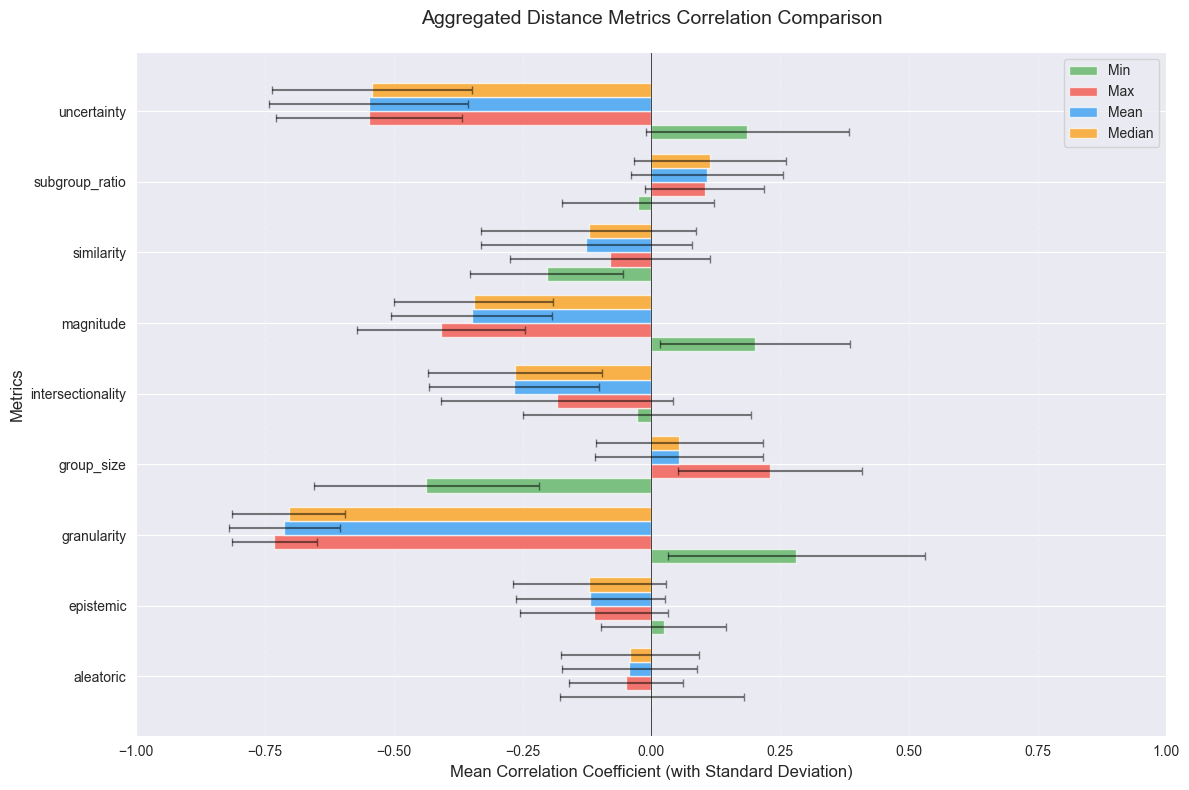


Detailed correlation statistics:
    calculated_metric    distance_type      mean       std       min       max
0           aleatoric     max_distance -0.048756  0.110307 -0.206145  0.222793
1           aleatoric    mean_distance -0.042603  0.131481 -0.288740  0.242787
2           aleatoric  median_distance -0.041029  0.133724 -0.309175  0.240133
3           aleatoric     min_distance  0.001258  0.179243 -0.354706  0.299405
4           epistemic     max_distance -0.110938  0.144192 -0.280967  0.243956
5           epistemic    mean_distance -0.118858  0.144590 -0.289698  0.219287
6           epistemic  median_distance -0.120205  0.147807 -0.304431  0.233308
7           epistemic     min_distance  0.023680  0.121357 -0.209657  0.254792
8         granularity     max_distance -0.731735  0.082320 -0.863436 -0.509215
9         granularity    mean_distance -0.712432  0.107445 -0.884273 -0.450040
10        granularity  median_distance -0.703964  0.109530 -0.885787 -0.449621
11        granular

In [32]:
aggregated_results = aggregate_and_plot_correlations(correlation_matrices_df)
plt.show()

# Print detailed statistics
print("\nDetailed correlation statistics:")
print(aggregated_results.to_string())

In [16]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from typing import Dict, Tuple


class UnifiedExperimentAnalyzer:
    def __init__(self, df: pd.DataFrame, target: str = 'mean_distance',
                 treatment_prefix: str = 'calculated_',
                 experiment_id_col: str = 'experiment_id'):
        """
        Initialize the analyzer with capability for both merged and individual analyses.
        """
        self.df = df
        self.target = target
        self.treatment_prefix = treatment_prefix
        self.experiment_id_col = experiment_id_col
        self.treatment_cols = [col for col in df.columns if col.startswith(treatment_prefix)]

    def analyze_data(self, X: pd.DataFrame, y: pd.Series) -> Dict:
        """
        Analyze a dataset and return comprehensive results.
        """
        # Standardize features
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        X_scaled = pd.DataFrame(X_scaled, columns=self.treatment_cols)

        # Fit models
        lr = LinearRegression()
        lr.fit(X_scaled, y)

        # Calculate confidence intervals using bootstrapping
        n_bootstrap = 1000
        coef_samples = np.zeros((n_bootstrap, len(self.treatment_cols)))

        for i in range(n_bootstrap):
            # Bootstrap sample
            indices = np.random.choice(len(X), size=len(X), replace=True)
            X_boot = X_scaled.iloc[indices]
            y_boot = y.iloc[indices]

            # Fit model
            lr_boot = LinearRegression()
            lr_boot.fit(X_boot, y_boot)
            coef_samples[i] = lr_boot.coef_

        # Calculate 95% confidence intervals
        ci_lower = np.percentile(coef_samples, 2.5, axis=0)
        ci_upper = np.percentile(coef_samples, 97.5, axis=0)

        # Calculate correlations and p-values
        correlations = {}
        for col in self.treatment_cols:
            correlation, p_value = stats.pearsonr(X[col], y)
            correlations[col] = {
                'correlation': correlation,
                'p_value': p_value
            }

        # Feature importance with confidence intervals
        feature_importance = pd.DataFrame({
            'feature': self.treatment_cols,
            'coefficient': lr.coef_,
            'ci_lower': ci_lower,
            'ci_upper': ci_upper,
            'importance': np.abs(lr.coef_)
        }).sort_values('importance', ascending=False)

        return {
            'model': lr,
            'coefficients': dict(zip(self.treatment_cols, lr.coef_)),
            'confidence_intervals': dict(zip(self.treatment_cols, zip(ci_lower, ci_upper))),
            'r2_score': lr.score(X_scaled, y),
            'cross_val_score': cross_val_score(lr, X_scaled, y, cv=5).mean(),
            'correlations': correlations,
            'feature_importance': feature_importance,
            'sample_size': len(X)
        }

    def compare_merged_vs_individual(self) -> Tuple[Dict, Dict]:
        """
        Compare merged analysis with individual experiment analyses.
        """
        # Merged analysis
        X_merged = self.df[self.treatment_cols]
        y_merged = self.df[self.target]
        merged_results = self.analyze_data(X_merged, y_merged)

        # Individual analyses
        individual_results = {}
        for exp_id in self.df[self.experiment_id_col].unique():
            exp_df = self.df[self.df[self.experiment_id_col] == exp_id]
            X_exp = exp_df[self.treatment_cols]
            y_exp = exp_df[self.target]
            individual_results[exp_id] = self.analyze_data(X_exp, y_exp)

        return merged_results, individual_results

    def plot_comparison(self, merged_results: Dict, individual_results: Dict):
        """
        Plot comparison between merged and individual analyses.
        """
        plt.figure(figsize=(15, 10))

        # Coefficient comparison plot
        plt.subplot(2, 1, 1)
        coef_data = []

        # Add merged coefficients
        for feature, coef in merged_results['coefficients'].items():
            ci_lower, ci_upper = merged_results['confidence_intervals'][feature]
            coef_data.append({
                'Feature': feature,
                'Coefficient': coef,
                'CI_lower': ci_lower,
                'CI_upper': ci_upper,
                'Analysis': 'Merged'
            })

        # Add individual coefficients
        for exp_id, results in individual_results.items():
            for feature, coef in results['coefficients'].items():
                ci_lower, ci_upper = results['confidence_intervals'][feature]
                coef_data.append({
                    'Feature': feature,
                    'Coefficient': coef,
                    'CI_lower': ci_lower,
                    'CI_upper': ci_upper,
                    'Analysis': f'Exp_{exp_id}'
                })

        coef_df = pd.DataFrame(coef_data)

        # Plot coefficients with confidence intervals
        sns.barplot(data=coef_df[coef_df['Analysis'] == 'Merged'],
                    x='Feature', y='Coefficient', color='blue', alpha=0.5)

        # Add error bars for confidence intervals
        for i, feature in enumerate(coef_df[coef_df['Analysis'] == 'Merged']['Feature']):
            plt.vlines(i,
                       coef_df[(coef_df['Analysis'] == 'Merged') & (coef_df['Feature'] == feature)]['CI_lower'].iloc[0],
                       coef_df[(coef_df['Analysis'] == 'Merged') & (coef_df['Feature'] == feature)]['CI_upper'].iloc[0],
                       color='black')

        plt.xticks(rotation=45)
        plt.title('Treatment Effects (Merged Analysis) with 95% Confidence Intervals')

        # R² comparison
        # plt.subplot(2, 1, 2)
        # r2_data = [('Merged', merged_results['r2_score'])]
        # r2_data.extend([(f'Exp_{exp_id}', res['r2_score'])
        #                for exp_id, res in individual_results.items()])
        # r2_df = pd.DataFrame(r2_data, columns=['Analysis', 'R²'])
        # sns.barplot(data=r2_df, x='Analysis', y='R²')
        # plt.title('Model R² Scores Comparison')

        plt.tight_layout()


def run_unified_analysis(data: pd.DataFrame) -> Tuple[Dict, pd.DataFrame]:
    """
    Run the complete analysis pipeline with focus on merged results.
    """
    analyzer = UnifiedExperimentAnalyzer(data)
    merged_results, individual_results = analyzer.compare_merged_vs_individual()

    # Generate summary statistics for merged analysis
    merged_summary = pd.DataFrame({
        'Feature': merged_results['feature_importance']['feature'],
        'Coefficient': merged_results['feature_importance']['coefficient'],
        'CI_Lower': merged_results['feature_importance']['ci_lower'],
        'CI_Upper': merged_results['feature_importance']['ci_upper'],
        'P_value': [merged_results['correlations'][f]['p_value']
                    for f in merged_results['feature_importance']['feature']]
    }).sort_values('Coefficient', key=abs, ascending=False)

    # Add significance indicators
    merged_summary['Significant'] = merged_summary['P_value'] < 0.05

    analyzer.plot_comparison(merged_results, individual_results)

    return merged_results, merged_summary

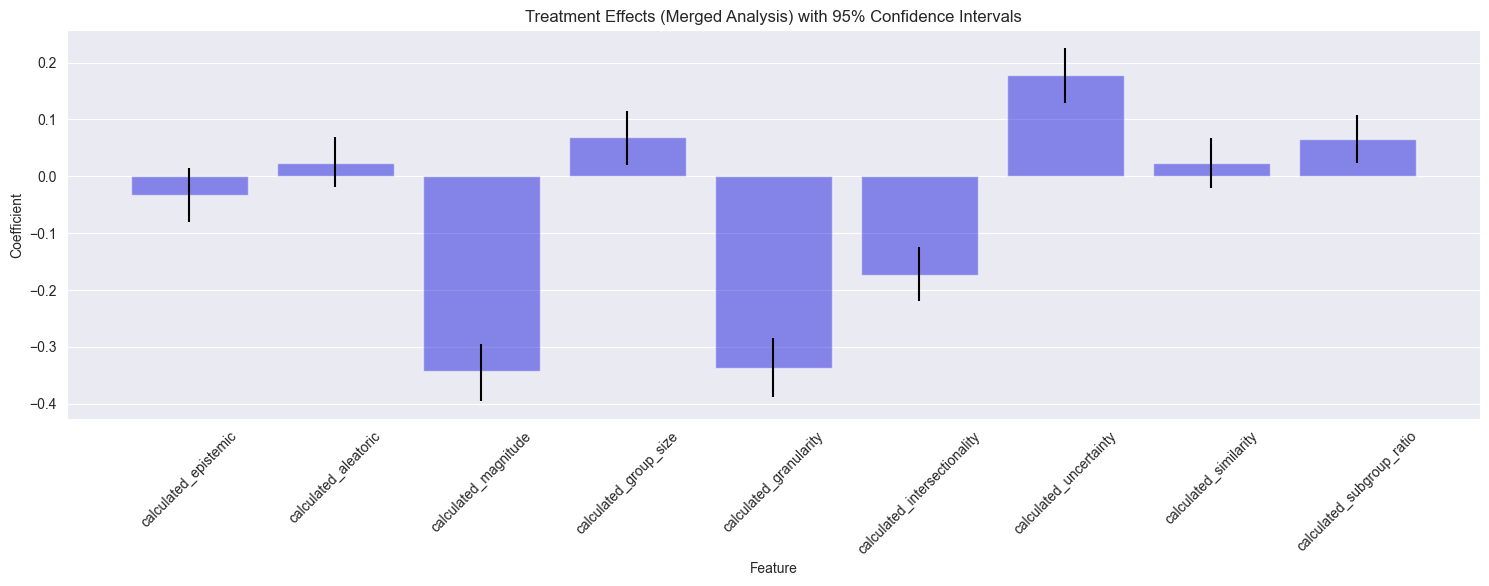

In [17]:
merged_results, summary = run_unified_analysis(distances_df.reset_index())
# View results
